## Import Libraries and Dataset

In [1]:
# Importing necessary libraries for data loading, data manipulation, and data visualization
from datasets import load_from_disk, concatenate_datasets
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [ ]:
####### This is the code to generate the tokens using SpaCy ####### 

# The run takes 3:30 hours approximately

# from datasets import load_dataset
# import re
# import spacy
# dataset_train=load_dataset("yelp_review_full",split='train')
# dataset_test=load_dataset("yelp_review_full",split='test')
# nlp = spacy.load("en_core_web_sm")

# # Preprocessing function for each review
# def clean_sentence(sentence):
#     sentence = re.sub(r'\\n',"",sentence)

#     #removing emoticons
#     sentence = re.sub(r'(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)',"", sentence)

#     #removing websites
#     sentence = re.sub(r"(http)?s?:?\/\/[A-Za-z0-9^,!.\/'+-=_?]+", "", sentence)

#     #numbers
#     sentence = re.sub(r"(\d+)(k)", r"\g<1> thousand", sentence)
#     sentence = re.sub(r"(\d+)([a-zA-z]+)", r"\g<1> \g<2>", sentence)
#     #convert numbers to words
#     sentence = re.sub(r"1", " one ", sentence)
#     sentence = re.sub(r"2", " two ", sentence)
#     sentence = re.sub(r"3", " three ", sentence)
#     sentence = re.sub(r"4", " four ", sentence)
#     sentence = re.sub(r"5", " five ", sentence)
#     sentence = re.sub(r"6", " six ", sentence)
#     sentence = re.sub(r"7", " seven ", sentence)
#     sentence = re.sub(r"8", " eight ", sentence)
#     sentence = re.sub(r"9", " nine ", sentence)
#     sentence = re.sub(r"0", " zero ", sentence)

#     # removing extraneous symbols
#     sentence = re.sub(r"[^A-Za-z0-9^,!.\/'+-=%]", " ", sentence)

#     # expanding contraction
#     sentence = re.sub(r"\'ve", " have ", sentence)
#     sentence = re.sub(r"n't", " not ", sentence)
#     sentence = re.sub(r"i'm", " i am ", sentence)
#     sentence = re.sub(r"\'re", " are ", sentence)
#     sentence = re.sub(r"\'d", " would ", sentence)
#     sentence = re.sub(r"\'ll", " will ", sentence)

#     #spacing out symbols
#     sentence = re.sub(r",", " ", sentence)
#     sentence = re.sub(r"\.", " . ", sentence)
#     sentence = re.sub(r"!", " ! ", sentence)
#     sentence = re.sub(r"\/", " ", sentence)
#     sentence = re.sub(r"\^", " ^ ", sentence)
#     sentence = re.sub(r"\+", " + ", sentence)
#     sentence = re.sub(r"\-", " - ", sentence)
#     sentence = re.sub(r"\=", " = ", sentence)
#     sentence = re.sub(r"'", " ", sentence)
#     sentence = re.sub(r":", " : ", sentence)
#     sentence = re.sub(r"%", " : ", sentence)

#     return sentence

# def preprocess_reviews(doc):
#     doc['text'] = clean_sentence(doc['text'])
#     return doc
    
# dataset_train = dataset_train.map(preprocess_reviews, num_proc = 4)
# dataset_test = dataset_test.map(preprocess_reviews, num_proc = 4)

# # Parsing function
# def parse_document(doc):
#   parsed_doc = nlp(doc['text'])
#   doc['sentences'] = [sent.text for sent in parsed_doc.sents]
#   doc['tokens'] = [w.text for w in parsed_doc]
#   return doc

# # Parse the reviews
# dataset_train = dataset_train.map(parse_document, num_proc = 4)
# dataset_test = dataset_test.map(parse_document, num_proc = 4)

# # Save to drive the preprocessed dataset
# dataset_train.save_to_disk('parsed_train.hf')
# dataset_test.save_to_disk('parsed_test.hf')


In [2]:
# Load the train and test datasets from disk: this dataset differs from the original 
# Yelp reviews dataset by having columns 'tokens' and 'sentences' that contain respectively
# the tokens and the sentences present in each review. This was done through SpaCy parsing.
train = load_from_disk('parsed_yelp_reviews//gianni_train.hf')
test = load_from_disk('parsed_yelp_reviews//gianni_test.hf')

## Preprocessing

In [3]:
# Function to remove punctuation from tokens of a document, returning a new column 'tokens_no_punc'
# that contains only tokens not corresponding to punctuation marks.
def remove_punctuation(doc):
    punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '
    doc['tokens_no_punc'] = [tok for tok in doc['tokens'] if tok not in punc]
    return doc

# Remove punctuation from tokens in test set
test = test.map(remove_punctuation, num_proc=4)

# Remove punctuation from tokens in train set
train = train.map(remove_punctuation, num_proc=4)

In [4]:
# Remove the 'tokens' column from both train and test dataframe, mantaining only the 'tokens_no_punc' column.
train = train.remove_columns('tokens')
test = test.remove_columns('tokens')

## Explorarory analysis

In [5]:
# Compute the length of a document in terms of number of tokens and number of sentences.
def calculate_n_tokens(doc):
    doc['length'] = len(doc['tokens_no_punc'])
    doc['n_sentences'] = len(doc['sentences'])
    return doc

test = test.map(calculate_n_tokens, num_proc= 4)
train = train.map(calculate_n_tokens, num_proc = 4)

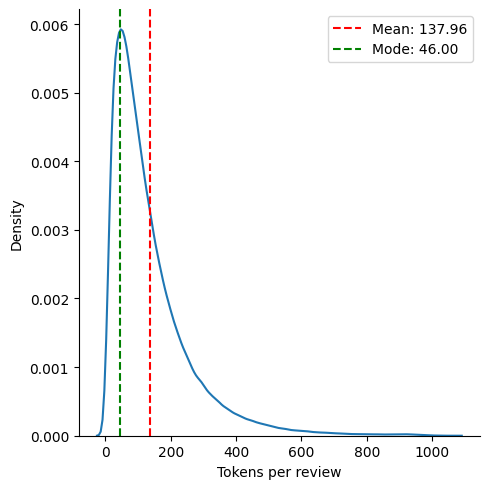

In [6]:
# Concatenate the lengths of documents from the train and test datasets
n_tokens_per_review = np.concatenate((np.array(train['length']),np.array(test['length']) ))

# Plot the distribution of document lengths using a kernel density estimate (KDE) plot
sns.displot(data=pd.DataFrame(n_tokens_per_review, columns= ['Tokens per review']), x='Tokens per review', kind="kde")

# Calculate the mean, median, and mode of the number of tokens per review
mean_length = np.mean(np.array(n_tokens_per_review))
median_length = np.median(np.array(n_tokens_per_review))
mode_length = np.argmax(np.bincount(n_tokens_per_review))

# Add vertical lines to the plot indicating the mean and mode of the number of token
plt.axvline(mean_length, color='r', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(mode_length, color='g', linestyle='--', label=f'Mode: {mode_length:.2f}')
plt.legend()

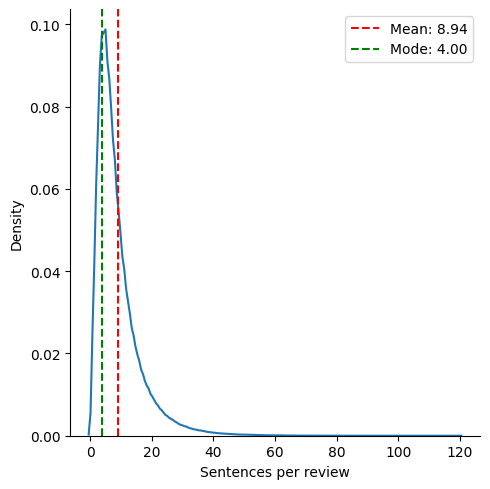

In [7]:
# Do the same for the number of sentences in each document.
n_sentences_per_review = np.concatenate((np.array(train['n_sentences']),np.array(test['n_sentences']) ))

sns.displot(data=pd.DataFrame(n_sentences_per_review, columns= ['Sentences per review']), x='Sentences per review', kind="kde")

mean_length = np.mean(np.array(n_sentences_per_review))
median_length = np.median(np.array(n_sentences_per_review))
mode_length = np.argmax(np.bincount(n_sentences_per_review))

plt.axvline(mean_length, color='r', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(mode_length, color='g', linestyle='--', label=f'Mode: {mode_length:.2f}')
plt.legend()

In [8]:
# Find the document with the maximum number of tokens
max_tokens_index = int(np.argmax(n_tokens_per_review))
max_tokens_length = train[max_tokens_index]['length']
max_tokens_label = train[max_tokens_index]['label']

print(f"The document with the maximum number of tokens has a length of {max_tokens_length} tokens.")
print(f"It corresponds to a {max_tokens_label} stars review.")

The document with the maximum number of tokens has a length of 1065 tokens.
It corresponds to a 3 stars review.


In [ ]:
# Let's find the most common tokens
# Convert the dataset to a pandas dataframe 
train_df = train.to_pandas()

# Since for each document there is a list of tokens, to have a single list with all the tokens we explode the dataframe on the tokens column
df_exploded = train.explode('tokens_no_punc')

# Count the the occurencies for each unique token and sort
words_count = df_exploded.groupby('tokens_no_punc').size().reset_index(name='count')
sorted_words_count = words_count.sort_values(by='count', ascending=False)

In [10]:
# We are interested to the most common words so the stopwords are not of interest

nltk.download('stopwords')
exclude_words = stopwords.words('english')
exclude_words.extend(["n't", "'s", '  ','...'])

# To accelerate times and only view the N top words
N = 1000
sorted_words_count_reduced = sorted_words_count[:N]

# View the tokens that are not stopwords
sorted_words_count_reduced = sorted_words_count_reduced[~sorted_words_count_reduced['tokens_no_punc'].isin(exclude_words)]
sorted_words_count_reduced[:20]

In [17]:
# Print the 10 most common tokens
print("Top 10 most common tokens in the train set:")
for token, count in zip(sorted_words_count_reduced['tokens_no_punc'][:10],sorted_words_count_reduced['count'][:10]):
    print(f"{token}\t-> {count}")

Top 10 most common tokens in the train set:
place	-> 250505
good	-> 250117
food	-> 241954
like	-> 207118
just	-> 205447
service	-> 184942
great	-> 177019
time	-> 174050
really	-> 147578
don	-> 122863


In [18]:
# Compute the average length of reviews for each star rating
labels = np.concatenate((np.array(train['label']), np.array(test['label']))) + 1
stars_vs_len_dict = {i+1:[] for i in range(5)} # Dictionary to store the lengths of reviews for each star rating

for len,star in zip(n_tokens_per_review, labels):
    stars_vs_len_dict[star].append(len)
stars_vs_len_dict = {lab: np.mean(np.array(len)) for lab, len in stars_vs_len_dict.items()}

In [19]:
# Print average length of reviews for each star rating
for star, length in stars_vs_len_dict.items():
    print(f"{star} stars : {length:.2f} tokens avg")

1 stars : 155.43 tokens avg
2 stars : 156.66 tokens avg
3 stars : 143.04 tokens avg
4 stars : 127.02 tokens avg
5 stars : 107.67 tokens avg


Length of reviews seems to be proportional to how bad was the experience. So longest reviews corresponds to the worst ones.

In [14]:
# Check if the dataset is balanced
unique, count = np.unique(labels, return_counts=True)

# Print the unique labels and their counts
print("Unique Labels:", unique)
print("Label Counts:", count)

Unique Labels: [1 2 3 4 5]
Label Counts: [140000 140000 140000 140000 140000]
